In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import desc
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
 # reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Determine lastest date in dataset
max_date = engine.execute("SELECT MAX(date) FROM measurement").fetchone()
max_date

('2017-08-23',)

In [10]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results
#precip = engine.execute("SELECT date, prcp FROM measurement WHERE date >date('now','-36 month')")
#for record in precip:
   #print(record)

In [11]:
# Calculate the date 1 year ago from the last data point in the databaseone_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [12]:
# Perform a query to retrieve the data and precipitation scores 
# Save the query results as a Pandas DataFrame and set the index to the date column
recent_precip_df = pd.read_sql(sql = "SELECT date, prcp FROM measurement WHERE date >= date(?,'-12 month')", con = engine, params = [max_date])
recent_precip_df.set_index('date', inplace=True)
recent_precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [13]:
# Sort the dataframe by date
sorted_recent_precip_df = recent_precip_df.sort_values(by=['date'])
sorted_recent_precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


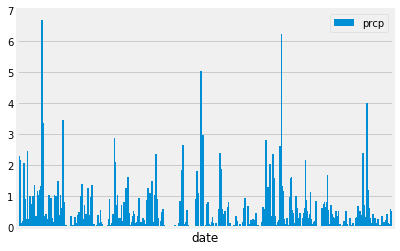

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
sorted_recent_precip_df.plot.bar(width=10)
plt.xticks([])
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
recent_precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Measurement).group_by(Measurement.station).count()
number_of_stations

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,
      func.count(Measurement.station)]

most_active_stations = session.query(*sel).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
most_active_station = most_active_stations[0][0]
most_active_station

'USC00519281'

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

temp_data = session.query(*temps).filter(Measurement.station==most_active_station).first()
temp_data

(54.0, 85.0, 71.66378066378067)

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
recent_temp_data_df = pd.read_sql(sql = "SELECT date, tobs FROM measurement WHERE date >= date(?,'-12 month')", con = engine, params = [max_date])
recent_temp_data_df.set_index('date', inplace=True)
recent_temp_data_df.head(10)

,tobs
date,
2016-08-23,81.0
2016-08-24,79.0
2016-08-25,80.0
2016-08-26,79.0
2016-08-27,77.0
2016-08-28,78.0
2016-08-29,78.0
2016-08-30,79.0
2016-08-31,80.0


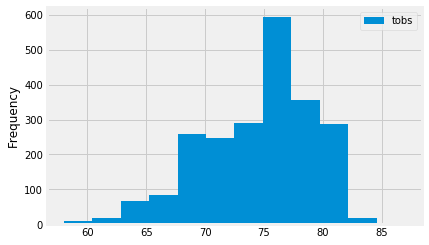

In [21]:
# Plot the results as a histogram
recent_temp_data_df.plot.hist(bins=12)
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        #start_date (string): A date string in the format %Y-%m-%d
        #end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        #TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
inital_trip = '2012-02-28 to 2012-03-05'
start_of_trip = '2012-02-28'
end_of_trip = '2012-03-05'

# Calculate the tmin, tavg, and tmax for your trip
trip_temps = calc_temps(start_of_trip, end_of_trip)
trip_temps

[(62.0, 69.57142857142857, 74.0)]

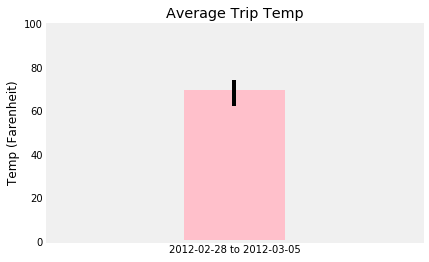

In [35]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_trip_temp = trip_temps[0][0]
avg_trip_temp = trip_temps[0][1]
max_trip_temp = trip_temps[0][2]

min_error = avg_trip_temp - min_trip_temp
max_error = max_trip_temp - avg_trip_temp

error_bars = np.array([[min_error], [max_error]])

plt.bar(inital_trip, avg_trip_temp, yerr=error_bars, color = "pink")
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Average Trip Temp')
plt.ylabel('Temp (Farenheit)')
plt.grid()

In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station,
        Station.name,
        func.sum(Measurement.prcp),
        Station.latitude,
        Station.longitude,
        Station.elevation
       ])

precip_station = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= start_of_trip)
                   .filter(Measurement.date <= end_of_trip)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

# Make query a dataframe
precip_table = pd.DataFrame(np.array(precip_station))

# Rename column headers
precip_table = precip_table.rename(columns={0: "Station", 1: "Location", 2: "Total Precipitation", 3: "Latitude", 4: "Longitude", 5: "Elevation"})
precip_table

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00519281,"WAIHEE 837.5, HI US",11.08,21.45167,-157.84888999999998,32.9
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",10.32,21.3331,-157.8025,152.4
2,USC00513117,"KANEOHE 838.1, HI US",5.79,21.4234,-157.8015,14.6
3,USC00518838,"UPPER WAHIAWA 874.3, HI US",3.8400000000000003,21.4992,-158.0111,306.6
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.92,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",1.1800000000000002,21.2716,-157.8168,3.0
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",0.76,21.3152,-157.9992,0.9
7,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.03,21.5213,-157.8374,7.0
8,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


In [ ]:
# Need assistance with the FLASK portion